In [0]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import models, transforms
from io import BytesIO


In [40]:
vgg= models.vgg19(pretrained=True).features
print(vgg)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [0]:
for param in vgg.parameters():
    param.requires_grad= False

In [0]:
train_on_gpu= torch.cuda.is_available()
if train_on_gpu:
    vgg.cuda()

In [0]:
def load_img(img_path, max_size=400, shape=None):
    image= Image.open(img_path).convert('RGB')
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    if shape is not None:
        size= shape
    transform= transforms.Compose([transforms.Resize(size),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.485, 0.456, 0.406), 
                                                        (0.229, 0.224, 0.225))])
    image= transform(image)[:3,:,:].unsqueeze(0)
    print(image.shape)
    return image

In [44]:
content= load_img('/content/new_york_day.jpg').to('cuda')
style= load_img('/content/hongkong_night.jpg', shape= content.shape[-2:]).to('cuda')

torch.Size([1, 3, 400, 710])
torch.Size([1, 3, 400, 710])


In [0]:
def convert_img(image):
    image= image.to('cpu').clone().detach()
    image= image.numpy().squeeze()
    image= image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

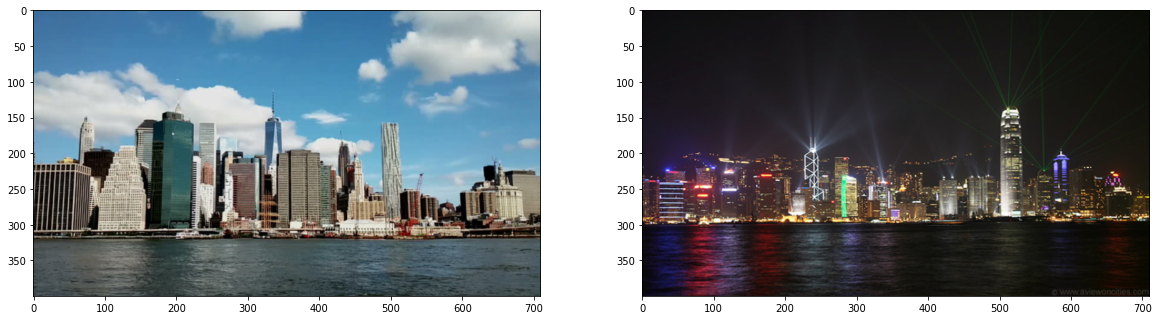

In [46]:
# display the images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
# content and style ims side-by-side
ax1.imshow(convert_img(content))
ax2.imshow(convert_img(style))

In [0]:
def get_features(image, model, layers=None):
    if layers is None:
        layers={'0': 'conv1_1',
                '5': 'conv2_1',
                '10': 'conv3_1',
                '19': 'conv4_1',
                '21': 'conv4_2',
                '28': 'conv5_1'}
    features= {}
    x=image
    for name, layer in model._modules.items():
            x=layer(x)
            if name in layers:
                features[layers[name]]=x
    return features

In [0]:
def gram_matrix(tensor):

    b, d,h,w= tensor.shape
    tensor= tensor.view(d,h*w)
    gram = torch.mm(tensor, tensor.t())
    
    return gram 

In [0]:
# get content and style features only once before forming the target image
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

# calculate the gram matrices for each layer of our style representation
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# create a third "target" image and prep it for change
# it is a good idea to start off with the target as a copy of our *content* image
# then iteratively change its style
target = content.clone().requires_grad_(True).to("cuda")

In [0]:
style_weights= {'conv1_1': 1.,
                'conv2_1': 0.8,
                'conv3_1': 0.3,
                'conv4_1': 0.2,
                'conv5_1':0.1}
content_weight= 1
style_weight= 1e5

In [0]:
import torch.optim as optim

Total loss:  3108562.0


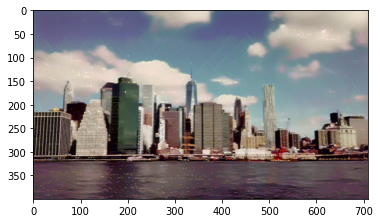

Total loss:  2154128.0


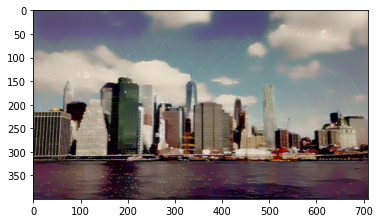

Total loss:  1438072.875


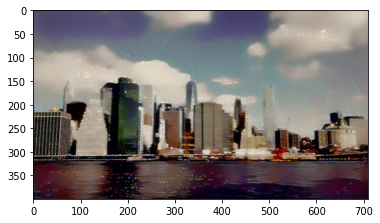

Total loss:  955138.3125


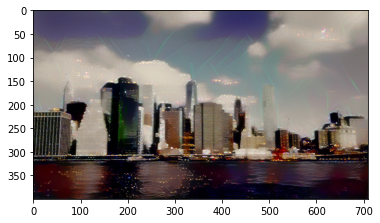

Total loss:  683507.3125


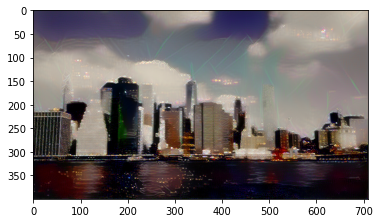

In [52]:
# for displaying the target image, intermittently
show_every = 400

# iteration hyperparameters
optimizer = optim.Adam([target], lr=0.003)
steps = 2000  # decide how many iterations to update your image (5000)

for ii in range(1, steps+1):
    
    # get the features from your target image
    target_features = get_features(target, vgg)
    
    # the content loss
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
    
    # the style loss
    # initialize the style loss to 0
    style_loss = 0
    # then add to it for each layer's gram matrix loss
    for layer in style_weights:
        # get the "target" style representation for the layer
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        _, d, h, w = target_feature.shape
        # get the "style" style representation
        style_gram = style_grams[layer]
        # the style loss for one layer, weighted appropriately
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        # add to the style loss
        style_loss += layer_style_loss / (d * h * w)
        
    # calculate the *total* loss
    total_loss = content_weight * content_loss + style_weight * style_loss
    
    # update your target image
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    # display intermediate images and print the loss
    if  ii % show_every == 0:
        print('Total loss: ', total_loss.item())
        plt.imshow(convert_img(target))
        plt.show()

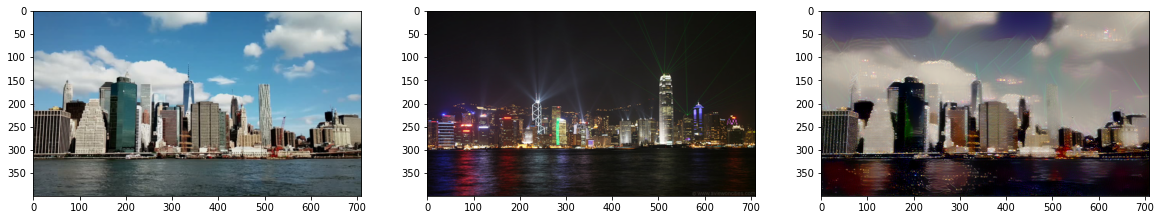

In [53]:
# display content and final, target image
fig, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(20, 10))
ax1.imshow(convert_img(content))
ax2.imshow(convert_img(style))
ax3.imshow(convert_img(target))


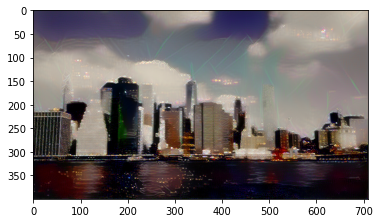

In [54]:
plt.imshow(convert_img(target))
plt.savefig('new_york_colorised.png', dpi=300, bbox_inches='tight')